In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode
from scipy import special
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

In [2]:
# 确定紧束缚模型大概得参数 

def H0_cos( q, v0 , NPoints=5): 
    h_0 = np.array( [ 4*(q+(i-NPoints))**2 - v0/2 for i in range( 2*NPoints+1 ) ] )
    h_1 =  -v0/4 * np.ones( 2*NPoints, np.int64) 
    h_1_1 = -v0/4 * np.ones( 2*NPoints, np.int64) 
    return np.diag(h_0, k=0) + np.diag(h_1, k=1) + np.diag(h_1_1, k=-1)

def tWannier( v0, xij=1., Nqs=200, band=0 ):
    L = Nqs # Lattice size
    qset = np.arange( 0, L)/L
    qsetSize = len(qset)
    #vZer0 = v0*jv(0,2*f)
    #vOne = v0*jv(1,2*f)*np.cos(phi)
    num_m = 20  # Number of plane waves 
    mset = np.arange(-num_m, num_m+1)
    msetSize = len(mset)
    
    # Diagonalize for all values of q
    cCoefs = np.empty( (qsetSize, msetSize, msetSize),dtype=complex )
    for qi,q in enumerate(qset):
        h0 = H0_cos(q, v0, num_m)
        w,v = np.linalg.eigh(h0)
        for j in range(msetSize):
            if v[:,j][-1] > 0 :
                cCoefs[qi][j] = v[:,j]
            else:
                cCoefs[qi][j] = -1.*v[:,j]
                
    x = np.linspace(-10, 10, 1001)
    xi = 0
    xj = xi + xij
    #Calculate Wannier
    wani = np.zeros_like( x, dtype=np.complex128)
    wanj = np.zeros_like( x, dtype=np.complex128)
    wanjd2 = np.zeros_like( x, dtype=np.complex128)
    for qi,q in enumerate(qset):
        for mj,m in enumerate(mset):
            cqm = cCoefs[qi][band][mj]
            wani   +=   cqm * np.exp( 1j * 2*np.pi * (x-xi) * (m+q) )
            wanj   +=   cqm * np.exp( 1j * 2*np.pi * (x-xj) * (m+q) )
            #wanj   += (-1j)**(band%2) * cqm * np.exp( 1j * 2*np.pi * (x* (m+q)-q*xj) )
            wanjd2 +=  cqm * (m+q)**2 * np.exp( 1j * 2*np.pi * (x-xj) * (m+q) )
    wani   = wani / L
    wanj   = wanj / L
    wanjd2 =  -1. * 4*np.pi**2 * wanjd2 / L
    
    integrand = -1*( -1*wani.conjugate()*wanjd2/(np.pi**2) -wani.conjugate()*v0*(np.cos(np.pi*x)**2)*wanj )
    integrand1 = wani.conjugate()*np.cos(np.pi*x)*wani
    integrand2 = wani.conjugate()*np.sin(np.pi*x)*wanj
    #-1*( -1*wani*wanjd2/(np.pi**2) -wani*vZer0*(np.cos(np.pi*x)**2)*wanj + wani*vOne*(np.sin(2*np.pi*x))*wanj )
    #t0fun = interpolate.interp1d(x,integrand,kind='quadratic')

    tInt = integrate.simpson( integrand, x)
    tInt1 = integrate.simpson( integrand1, x)
    tInt2 = integrate.simpson( integrand2, x)
    
    return tInt, tInt1, tInt2

In [3]:
t0,t1,t2 = tWannier( 4, xij=1., Nqs=200, band=0 )
print(t0)
print(t2)
print(t1)
print(t1*t2*t1)
print(t1*t1*t1)

(0.08549007025152847+3.55317181823527e-18j)
(0.0658258286106041-7.332271482595254e-18j)
(0.8278855575836604-1.5744030232521926e-35j)
(0.04511666065433817-5.0254985206891914e-18j)
(0.5674282048629234-3.237261502020372e-35j)


In [84]:
def getRaman1(o1, s1, m1, n1, l1):  # 找 -M1 sin(kx) cos(ky) cos(kz) taux sigmay 对应的耦合
    if o1 == 'g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, 1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, 1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, -1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, -1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, 1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, 1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, -1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, -1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key, coefffinal

    
def getRaman2(o1,s1,m1,n1,l1): #找 M1 cos(kx) sin(ky) cos(kz) taux sigmax 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, -1j * 1 / 8),
            (0, -1, 0, 1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, -1j * 1 / 8),
            (-1, -1, 0, 1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, -1j * 1 / 8),
            (1, 0, 1, 1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, -1j * 1 / 8),
            (0, 0, 1, 1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key,coefffinal

def getRaman3(o1,s1,m1,n1,l1): #找 M2,0 cos(kx) cos(ky) sin(kz) taux sigmaz 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1 
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinoperator(o1,s1,m1,n1,l1): #找 M2,0 cos(kx) cos(ky) sin(kz) taux sigmaz 对应的耦合
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal


def getRaman4(o1,s1,m1,n1,l1): #找 M2,1 cos(kx) cos(ky) cos(kz) taux sigma0 对应的耦合
    if o1=='g':
        o2='e' #o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0,  1 / 8),     
            (0, 0, -1,  1 / 8),
            (0, -1, 0,  1 / 8),
            (0, -1, -1,  1 / 8),
            (-1, 0, 0,  1 / 8),     
            (-1, 0, -1, 1 / 8),
            (-1, -1, 0,  1/ 8),
            (-1, -1, -1, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2='g'#o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1,  1 / 8),     
            (1, 1, 0,  1 / 8),
            (1, 0, 1,  1 / 8),
            (1, 0, 0,  1 / 8),
            (0, 1, 1,  1 / 8),     
            (0, 1, 0, 1 / 8),
            (0, 0, 1,  1/ 8),
            (0, 0, 0, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getBasis(numm,numn,numl):
    #q = np.array([qx,qy,qz])  
    truncm = list(range(-numm, numm + 1))
    truncn = list(range(-numn, numn + 1))
    truncl = list(range(-numl, numl + 1))
    basis = []
    index_map = {}
    idx = 0
    for o in ['g', 'e']:
        for s in ['up', 'down']:
            for mx in truncm:
                for ny in truncn:
                    for lz in truncl:
                        basis.append((o, s, mx, ny, lz))
                        index_map[(o, s, mx, ny, lz)] = idx
                        idx += 1
    return basis,index_map

def getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (px1**2 + py1**2 + pz1**2) - 0.5*(V0+V0+Vz) #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic

        # Zeeman 项
        if o1 == 'g':
            H[i, i] += delta 
        elif o1 == 'e':
            H[i, i] -= delta 
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        
        for dx in [-1, 1]:
            key = (o1, s1, m1 + dx, n1, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dy in [-1, 1]:
            key = (o1, s1, m1, n1 + dy, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dz in [-1, 1]:
            key = (o1, s1, m1, n1, l1 + dz)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -Vz / 4

        key1,coeff1 = getRaman1(o1,s1,m1,n1,l1)
        key2,coeff2 = getRaman2(o1,s1,m1,n1,l1)
        key3,coeff3 = getRaman3(o1,s1,m1,n1,l1)
        key4,coeff4 = getRaman4(o1,s1,m1,n1,l1)

        for keyi1,keyv1 in enumerate(key1):
            j = index_map.get(keyv1)
            if j is not None:
                H[i, j] += M1*coeff1[keyi1]  # 可根据 σ 的结构继续细化

        for keyi2,keyv2 in enumerate(key2):
            j = index_map.get(keyv2)
            if j is not None:
                H[i, j] += M1*coeff2[keyi2]

        for keyi3,keyv3 in enumerate(key3):
            j = index_map.get(keyv3)
            if j is not None:
                H[i, j] += M20*coeff3[keyi3]

        for keyi4,keyv4 in enumerate(key4):
            j = index_map.get(keyv4)
            if j is not None:
                H[i, j] += M21*coeff4[keyi4]
    return H

def spinProjectionOperator(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperator(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator

def getSpinsector(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperator(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin

def getBasisrealspace(o1,qx,qy,qz,n,m,l):
    x = np.linspace(-10, 10, 1001)
    y = np.linspace(-10, 10, 1001)
    z = np.linspace(-10, 10, 1001)
    if o1 == 'g':
        shift = np.array([0, 0, 0])
    elif o1 == 'e':
        shift = np.array([1, 1, 1])
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    px1 = qx + 2 * m + shift[0]
    py1 = qy + 2 * n + shift[1]
    pz1 = qz + 2 * l + shift[2]
    return np.exp(1j*px1*np.pi*x + 1j*py1*np.pi*y + 1j*pz1*np.pi*z)

def Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    #H1 =  csr_matrix(H)
    #eigvals, eigvecs = eigsh(H1, k=10, which='SA',tol=1e-12)
    eigvals,eigvecs = np.linalg.eigh(H)
    #indexE = np.argsort(eigvals)
    #_,eigvec = np.linalg.eigh(H)
    eigvec1 = eigvecs[:,0].reshape(len(H),1)
    eigvec2 = eigvecs[:,1].reshape(len(H),1)
    P = eigvec1@(eigvec1.T.conjugate()) + eigvec2@(eigvec2.T.conjugate())
    return P

def Willsonloop(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N):
    t = np.arange(0,2*N,2)/N*np.pi
    U = np.zeros((2,2),dtype=complex)
    deltaini = delta0-delta*np.cos(t[0])
    M21i = M21*np.sin(t[0])
    Hin = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21i,deltaini)
    #H1 =  csr_matrix(H)
    eigvals, eigvecs = np.linalg.eigh(Hin)#eigsh(H1, k=10, which='SA',tol=1e-12)
    #indexE = np.argsort(eigvals)
    Pro = np.eye(len(Hin),dtype=complex)
    for i in range(len(t)):
        M21t = M21*np.sin(t[i])
        deltat = delta0-delta*np.cos(t[i])
        Pro = Projection(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21t,deltat)@Pro
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvecs[:,i].reshape(len(Hin),1)).T.conjugate())@Pro@(eigvecs[:,j].reshape(len(Hin),1)))[0][0]
    return U

In [81]:
H=spinProjectionOperator(2,2,2)

In [83]:
np.max(np.abs(H.T.conjugate()-H))

np.float64(0.0)

In [91]:
V0 = 4.0
Vz = 4.0
delta0 = 0.17*3
delta = 0.17
M1 = 1
M20 = 1
M21 = 0.15
numm= 2
numn= 2
numl= 2
qx = 0
qy = 0
qz = 0
_,_,_,Espin = getSpinsector(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta)


In [92]:
Espin

array([-2.66136317,  2.66136317])

In [93]:
V0 = 4.0
Vz = 4.0
delta0 = 0.17*3
delta = 0.17
M1 = 1
M20 = 1
M21 = 0.15
numm= 2
numn= 2
numl= 2
qx = 0
qy = 0
qz = np.linspace(-1,1,100)
t = np.linspace(0,2*np.pi,100)
M21t = M21*np.sin(t)
deltat = delta0-delta*np.cos(t)
Eband = np.zeros((len(qz),len(t),10))
Espin = np.zeros((len(qz),len(t),2))
for i in np.arange(len(qz)):
    for j in np.arange(len(t)):
        _, _, Eband[i,j], Espin[i,j] = getSpinsector(qx,qy,qz[i],numm,numn,numl,V0,Vz,M1,M20,M21t[j],deltat[j])
        #print(Eband[i,j])
        #print(Espin[i,j])

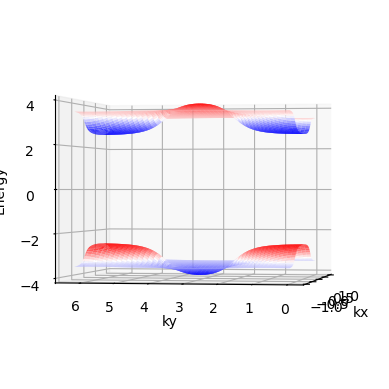

In [94]:
KZ,T = np.meshgrid(qz,t,indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制3D能带图
#ax.plot_surface(KZ, T, Eband[:,:,0], cmap='bwr')
#ax.plot_surface(KZ, T, Eband[:,:,2], cmap='bwr')
#ax.plot_surface(KZ, T, Eband[:,:,1], cmap='bwr')
#ax.plot_surface(KZ, T, Eband[:,:,3], cmap='bwr')
#ax.plot_surface(KZ, T, Eband[:,:,4], cmap='bwr')
#ax.plot_surface(KZ, T, Eband[:,:,5], cmap='bwr')
ax.plot_surface(KZ, T, Espin[:,:,0], cmap='bwr')
ax.plot_surface(KZ, T, Espin[:,:,1], cmap='bwr')
# 设置标签
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('Energy')
ax.view_init(elev=0,azim=190)
# 显示图形
plt.show()

In [34]:
#计算Wilson loop
V0 = 4.0
Vz = 4.0
delta0 = 0.17*3
delta = 0.17
M1 = 1
M20 =1
M21 = 0.15
numm= 2
numn= 2
numl= 2
qx = 1
qy = 1
N= 100
qz =  np.linspace(-1,1,50)
Energy = np.zeros((len(qz),2),dtype=complex)
for i in np.arange(len(qz)):
    U = Willsonloop(qx,qy,qz[i],numm,numn,numl,V0,Vz,M1,M20,M21,delta0,delta,N)
    Energy[i],_ = np.linalg.eig(U)

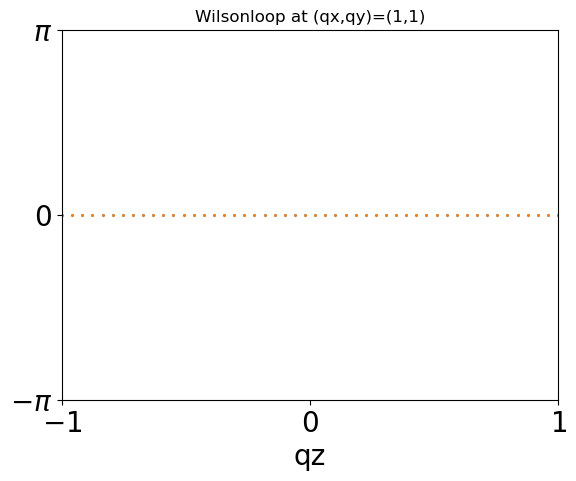

In [35]:
plt.scatter(qz,(1j*np.log(Energy[:,0])).real,s=1)
plt.scatter(qz,(1j*np.log(Energy[:,1])).real,s=1)
plt.xlim(-1,1)
#plt.ylim(-np.pi,np.pi)
plt.xticks([-1,0,1],[r'$-1$', r'$0$', r'$1$'],fontsize=20)
plt.yticks([-np.pi,0,np.pi],[r'$-\pi$', r'$0$', r'$\pi$'],fontsize=20)
plt.xlabel('qz',fontsize=20)
plt.title('Wilsonloop at (qx,qy)=(1,1)')
plt.savefig('WilsonLoop (1,1)')

In [3]:
V0 = 4.0
Vz = 4.0
delta = 0.0
M1 = 1
M20 = 1
M21 = 0.05
numm= 2
numn= 2
numl= 2
qx = np.linspace(-1,1,30)
qy = np.linspace(-1,1,30)
qz =  np.linspace(-1,1,10)
Energy = np.zeros((len(qx),len(qy),len(qz),6))
for qxi in np.arange(len(qx)):
    for qyj in np.arange(len(qy)):
        for qzk in np.arange(len(qz)):
            H = getHam(qx[qxi],qy[qyj],qz[qzk],numm,numn,numl,V0,Vz,M1,M20,M21,delta)
            H1 =  csr_matrix(H)
            eigvals, eigvecs = eigsh(H1, k=6, which='SA')  # 取最低能态
            indexE = np.argsort(eigvals)
            Energy[qxi][qyj][qzk] = eigvals[indexE]

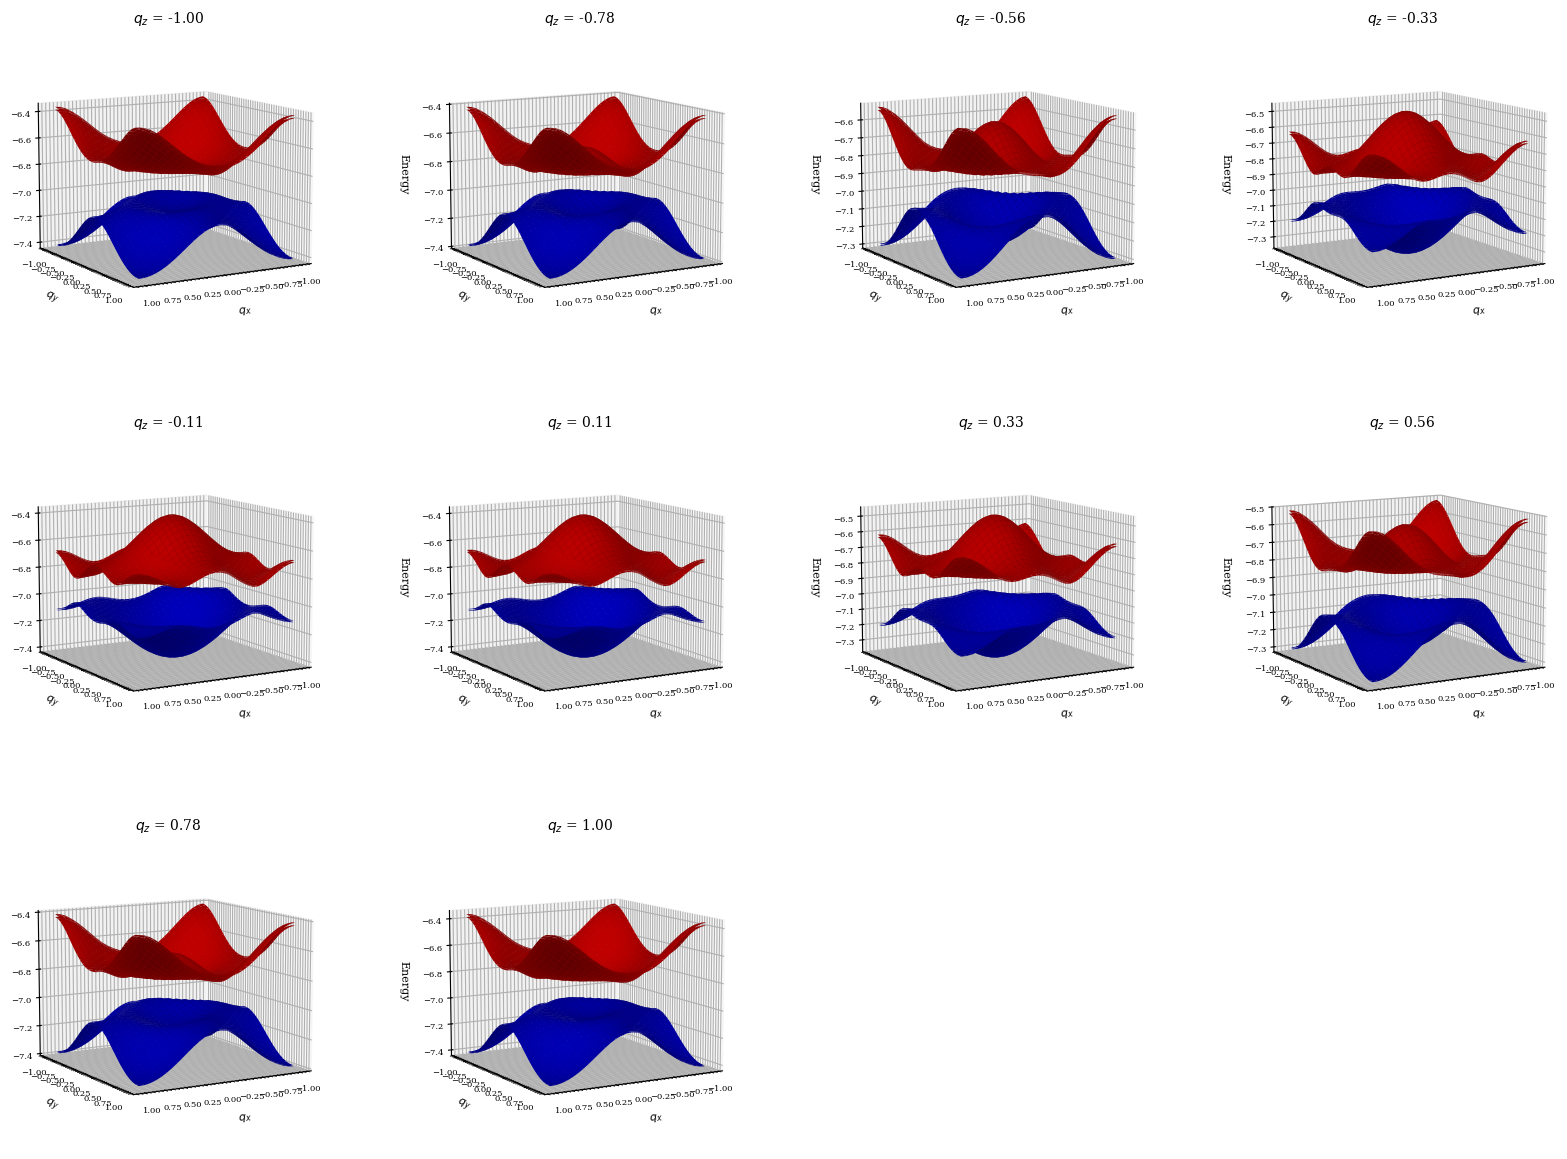

In [4]:
fig = plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # 调整子图间距
vmin, vmax = np.min(Energy[:,:,:]), np.max(Energy[:,:,:])

# 绘制每个qz对应的子图
for k in range(len(qz)):
    ax = fig.add_subplot(5, 4, k+1, projection='3d')  # 5行4列布局
    Qx, Qy = np.meshgrid(qx, qy, indexing='ij')
    
    # 绘制两个能带曲面
    surf0 = ax.plot_surface(Qx, Qy, Energy[:, :, k,0], 
                           color='b', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf1 = ax.plot_surface(Qx, Qy, Energy[:, :, k,1], 
                           color='b', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf2 = ax.plot_surface(Qx, Qy, Energy[:, :,k, 2], 
                           color='r', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf3 = ax.plot_surface(Qx, Qy, Energy[:, :, k,3], 
                           color='r', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    
    # 设置标题和坐标轴
    ax.set_title(f'$q_z$ = {qz[k]:.2f}', fontsize=10)
    ax.set_xlabel('$q_x$', fontsize=8, labelpad=0)
    ax.set_ylabel('$q_y$', fontsize=8, labelpad=0)
    ax.set_zlabel('Energy', fontsize=8, labelpad=0)
    
    # 调整视角和刻度
    ax.view_init(10, 60)  # 统一视角
    ax.tick_params(axis='both', which='major', labelsize=6, pad=0)

# 添加共享颜色条
#cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 右侧颜色条位置
#fig.colorbar(surf0, cax=cax, label='Energy')

#plt.show()

In [ ]:
V0 = 4.0
Vz = 4.0
delta0 = 0.17
delta = 0.17
M1 = 1.9
M20 =1.9
M21 = 0.3
t = np.linspace(-np.pi,np.pi,12)
M21t = M21*np.sin(t)
deltat = delta0-delta*np.cos(t)
numm= 2
numn= 2
numl= 2
qx = np.linspace(-1,1,30)
qy = np.linspace(-1,1,30)
Energy = np.zeros((len(qx),len(qy),len(t),4))
for qxi in np.arange(len(qx)):
    for qyj in np.arange(len(qy)):
        for qzk in np.arange(len(t)):
            H = getHam(qx[qxi],qy[qyj],0,numm,numn,numl,V0,Vz,M1,M20,M21t[qzk],deltat[qzk])
            #H1 =  csr_matrix(H)
            eigvals, eigvecs = np.linalg.eigh(H)#eigsh(H1, k=8, which='SA')  # 取最低能态
            #indexE = np.argsort(eigvals)
            Energy[qxi][qyj][qzk] = eigvals[0:4]

In [ ]:


fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.1, wspace=0.1)

vmin, vmax = np.min(Energy), np.max(Energy)

ncols = 4
nrows = int(np.ceil(len(t) / ncols))

# 设置轴刻度点和对应标签
tick_vals = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']

for k in range(len(t)):
    row = k // ncols
    col = k % ncols

    ax = fig.add_subplot(nrows, ncols, k + 1, projection='3d')
    Qx, Qy = np.meshgrid(qx, qy, indexing='ij')

    for band in range(4):
        ax.plot_surface(Qx, Qy, Energy[:, :, k, band],
                        cmap='bwr', vmin=vmin, vmax=vmax,
                        alpha=1, rstride=1, cstride=1)

    # 将 t[k] 映射为 π 单位标题
    t_label = f"${t[k]/np.pi:.2g}\\pi$" if t[k] != 0 else "$0$"
    ax.set_title(f'$t$ = {t_label}', fontsize=15)

    if row == nrows - 1:
        ax.set_xlabel('$q_x$', fontsize=15, labelpad=15)
        ax.set_xticks(tick_vals)
        ax.set_xticklabels(tick_labels, fontsize=7)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    if col == 0:
        ax.set_ylabel('$q_y$', fontsize=15, labelpad=15)
        ax.set_yticks(tick_vals)
        ax.set_yticklabels(tick_labels, fontsize=7)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    if k == 0:
        ax.set_zlabel('Energy', fontsize=15, labelpad=15)
    else:
        ax.set_zticks([])
        ax.set_zticklabels([])

    ax.view_init(10, 60)
    ax.tick_params(axis='both', which='major', labelsize=15, pad=0)
plt.savefig('EnergyTB.png')
plt.show()

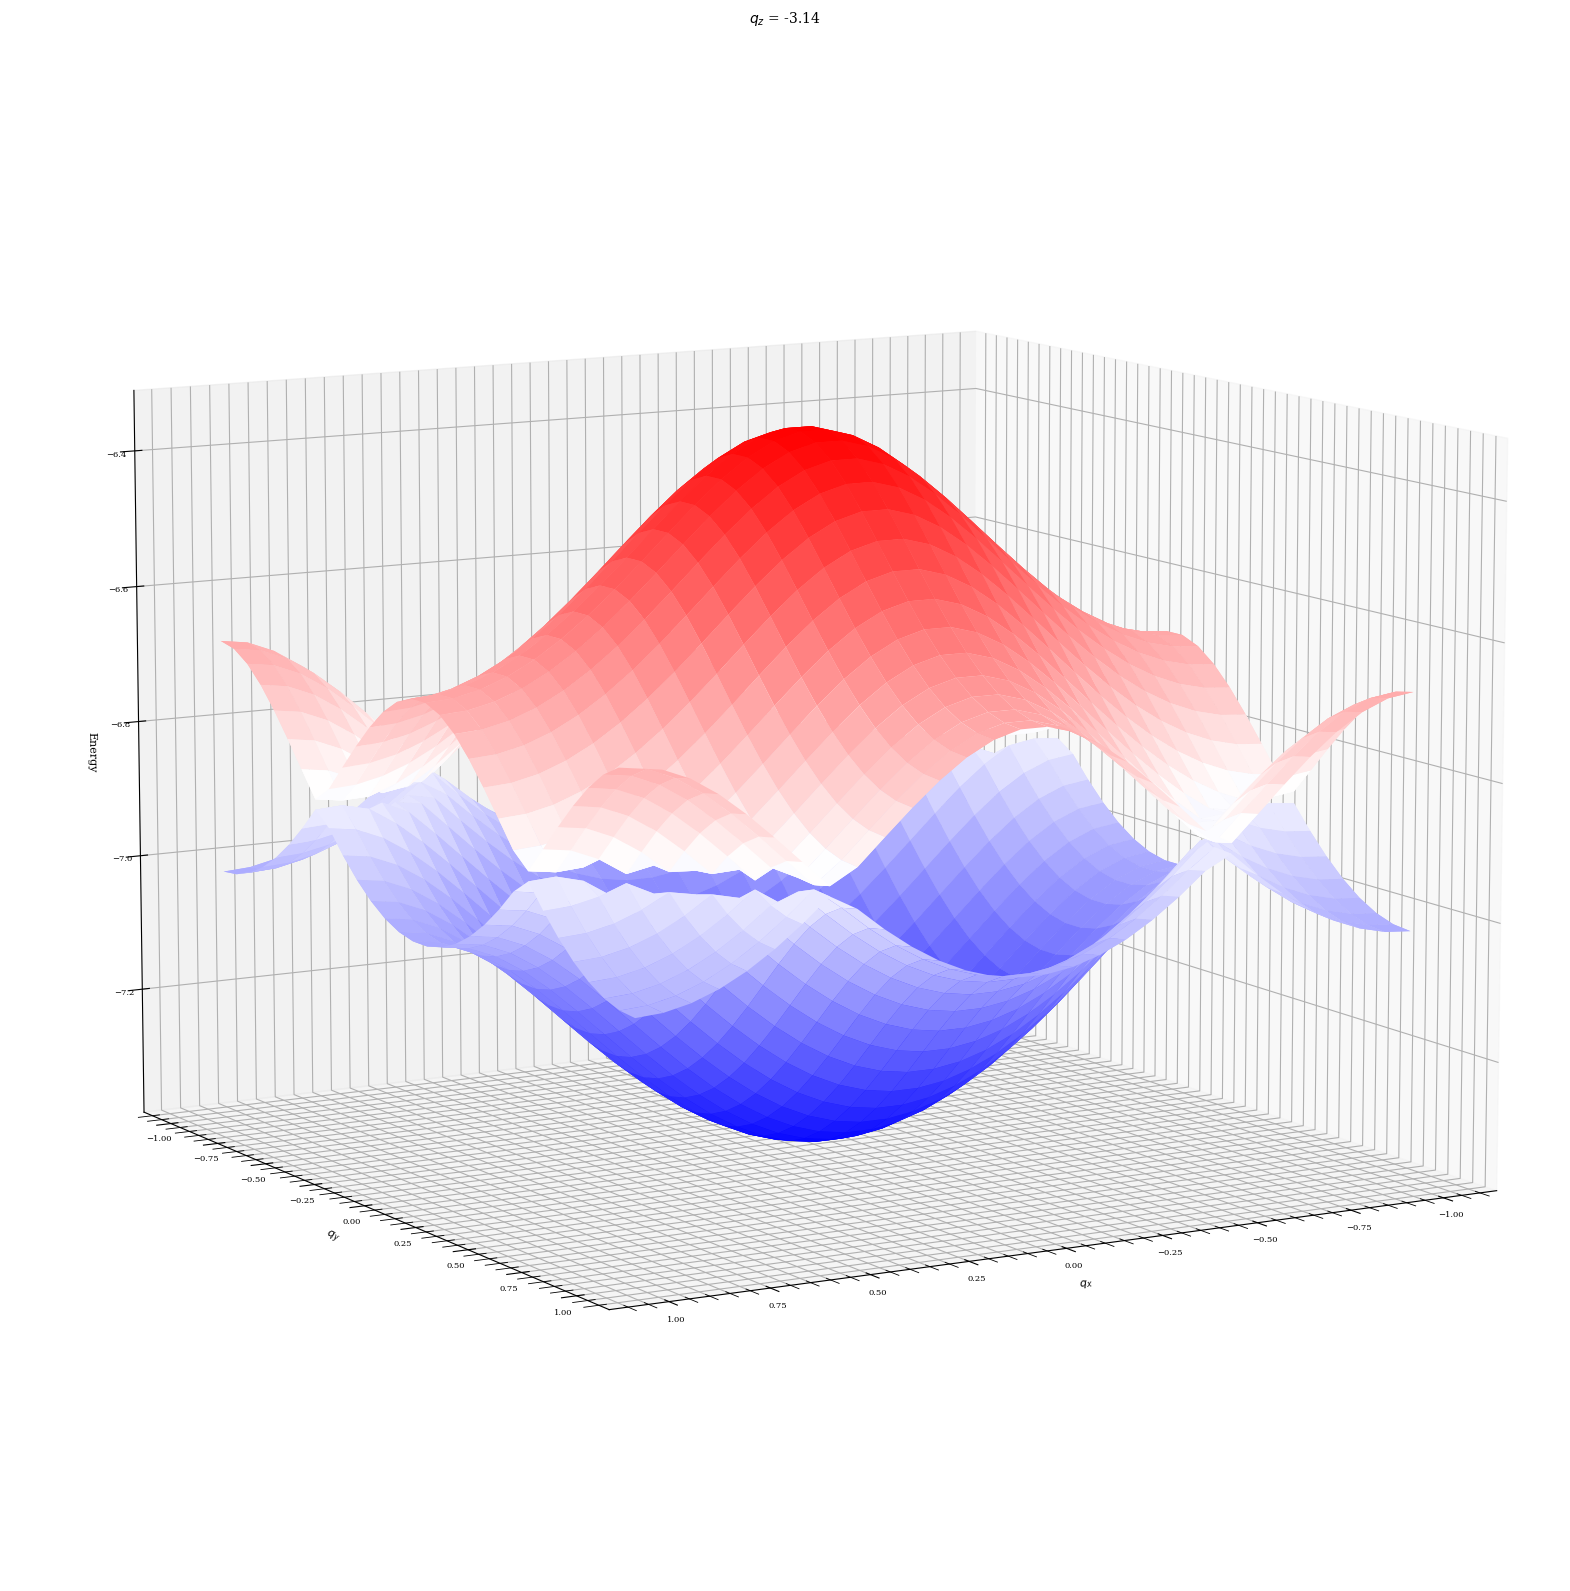

In [14]:
fig = plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # 调整子图间距
vmin, vmax = np.min(Energy[:,:,:]), np.max(Energy[:,:,:])

# 绘制每个qz对应的子图
for k in range(len(t)):
    ax = fig.add_subplot(  1, 1, k+1, projection='3d')  # 5行4列布局
    Qx, Qy = np.meshgrid(qx, qy, indexing='ij')
    
    # 绘制两个能带曲面
    surf0 = ax.plot_surface(Qx, Qy, Energy[:, :, k,0], 
                           cmap='bwr', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf1 = ax.plot_surface(Qx, Qy, Energy[:, :, k,1], 
                           cmap='bwr', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf2 = ax.plot_surface(Qx, Qy, Energy[:, :,k, 2], 
                           cmap='bwr', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    surf3 = ax.plot_surface(Qx, Qy, Energy[:, :, k,3], 
                           cmap='bwr', vmin=vmin, vmax=vmax,
                           alpha=1, rstride=1, cstride=1)
    
    # 设置标题和坐标轴
    ax.set_title(f'$q_z$ = {t[k]:.2f}', fontsize=10)
    ax.set_xlabel('$q_x$', fontsize=8, labelpad=0)
    ax.set_ylabel('$q_y$', fontsize=8, labelpad=0)
    ax.set_zlabel('Energy', fontsize=8, labelpad=0)
    
    # 调整视角和刻度
    ax.view_init(10, 60)  # 统一视角
    ax.tick_params(axis='both', which='major', labelsize=6, pad=0)


In [ ]:
def nonAbeianUxy(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdkx = testHamiltonian(kx+dkx,ky, kz,kw,m,c)
    Hdky = testHamiltonian(kx,ky+dky,kz,kw,m,c)
    Hdkxdky = testHamiltonian(kx+dkx,ky+dky,kz,kw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkx = np.linalg.eigh(Hdkx)
    _,eigvecdky = np.linalg.eigh(Hdky)
    _,eigvecdkxdky = np.linalg.eigh(Hdkxdky)

    Ux = np.zeros((2,2),dtype=complex)
    Uyx = np.zeros((2,2),dtype=complex)
    Uy = np.zeros((2,2),dtype=complex)
    Uxy = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Ux[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkx[:,j].reshape(4,1)))[0][0]
            Uyx[i,j] = (((eigvecdkx[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdky[:,j].reshape(4,1)))[0][0]
            Uxy[i,j] = (((eigvecdky[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdky[:,j].reshape(4,1)))[0][0]
            Uy[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdky[:,j].reshape(4,1)))[0][0]
    U = Ux@Uyx@np.linalg.inv(Uxy)@np.linalg.inv(Uy)
    return logm(U)

def nonAbeianUzw(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdkz = testHamiltonian(kx,ky,kz+dkz,kw,m,c)
    Hdkw = testHamiltonian(kx,ky,kz,kw+dkw,m,c)
    Hdkzdkw = testHamiltonian(kx,ky,kz+dkz,kw+dkw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkz = np.linalg.eigh(Hdkz)
    _,eigvecdkw = np.linalg.eigh(Hdkw)
    _,eigvecdkzdkw = np.linalg.eigh(Hdkzdkw)
    Uz = np.zeros((2,2),dtype=complex)
    Uwz = np.zeros((2,2),dtype=complex)
    Uw = np.zeros((2,2),dtype=complex)
    Uzw = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Uz[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkz[:,j].reshape(4,1)))[0][0]
            Uwz[i,j] = (((eigvecdkz[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkzdkw[:,j].reshape(4,1)))[0][0]
            Uzw[i,j] = (((eigvecdkw[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkzdkw[:,j].reshape(4,1)))[0][0]
            Uw[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkw[:,j].reshape(4,1)))[0][0]
    U = Uz@Uwz@np.linalg.inv(Uzw)@np.linalg.inv(Uw)
    return logm(U)

def nonAbeianUwx(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdkx = testHamiltonian(kx+dkx,ky, kz,kw,m,c)
    Hdkw = testHamiltonian(kx,ky,kz,kw+dkw,m,c)
    Hdkxdkw = testHamiltonian(kx+dkx,ky,kz,kw+dkw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkx = np.linalg.eigh(Hdkx)
    _,eigvecdkw = np.linalg.eigh(Hdkw)
    _,eigvecdkxdkw = np.linalg.eigh(Hdkxdkw)
    Uw = np.zeros((2,2),dtype=complex)
    Uxw = np.zeros((2,2),dtype=complex)
    Uwx = np.zeros((2,2),dtype=complex)
    Ux = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Uw[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkw[:,j].reshape(4,1)))[0][0]
            Uwx[i,j] = (((eigvecdkx[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdkw[:,j].reshape(4,1)))[0][0]
            Uxw[i,j] = (((eigvecdkw[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdkw[:,j].reshape(4,1)))[0][0]
            Ux[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkx[:,j].reshape(4,1)))[0][0]
    U = Uw@Uxw@np.linalg.inv(Uwx)@np.linalg.inv(Ux)
    return logm(U)

def nonAbeianUzy(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdkz = testHamiltonian(kx,ky,kz+dkz,kw,m,c)
    Hdky = testHamiltonian(kx,ky+dky,kz,kw,m,c)
    Hdkzdky = testHamiltonian(kx,ky+dky,kz+dkz,kw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkz = np.linalg.eigh(Hdkz)
    _,eigvecdky = np.linalg.eigh(Hdky)
    _,eigvecdkzdky = np.linalg.eigh(Hdkzdky)
    Uz = np.zeros((2,2),dtype=complex)
    Uyz = np.zeros((2,2),dtype=complex)
    Uzy = np.zeros((2,2),dtype=complex)
    Uy = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Uz[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkz[:,j].reshape(4,1)))[0][0]
            Uyz[i,j] = (((eigvecdkz[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkzdky[:,j].reshape(4,1)))[0][0]
            Uzy[i,j] = (((eigvecdky[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkzdky[:,j].reshape(4,1)))[0][0]
            Uy[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdky[:,j].reshape(4,1)))[0][0]
    U = Uz@Uyz@np.linalg.inv(Uzy)@np.linalg.inv(Uy)
    return logm(U)

def nonAbeianUzx(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdkz = testHamiltonian(kx,ky,kz+dkz,kw,m,c)
    Hdkx = testHamiltonian(kx+dkx,ky,kz,kw,m,c)
    Hdkxdkz = testHamiltonian(kx+dkx,ky,kz+dkz,kw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdkz = np.linalg.eigh(Hdkz)
    _,eigvecdkx = np.linalg.eigh(Hdkx)
    _,eigvecdkxdkz = np.linalg.eigh(Hdkxdkz)
    Uz = np.zeros((2,2),dtype=complex)
    Uxz = np.zeros((2,2),dtype=complex)
    Uzx = np.zeros((2,2),dtype=complex)
    Ux = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Uz[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkz[:,j].reshape(4,1)))[0][0]
            Uxz[i,j] = (((eigvecdkz[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdkz[:,j].reshape(4,1)))[0][0]
            Uzx[i,j] = (((eigvecdkx[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkxdkz[:,j].reshape(4,1)))[0][0]
            Ux[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkx[:,j].reshape(4,1)))[0][0]
    U = Uz@Uxz@np.linalg.inv(Uzx)@np.linalg.inv(Ux)
    return logm(U)

def nonAbeianUyw(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    H = testHamiltonian(kx,ky,kz,kw,m,c)
    Hdky = testHamiltonian(kx,ky+dky,kz,kw,m,c)
    Hdkw = testHamiltonian(kx,ky,kz,kw+dkw,m,c)
    Hdkydkw = testHamiltonian(kx,ky+dky,kz,kw+dkw,m,c)
    _,eigvec = np.linalg.eigh(H)
    _,eigvecdky = np.linalg.eigh(Hdky)
    _,eigvecdkw = np.linalg.eigh(Hdkw)
    _,eigvecdkydkw = np.linalg.eigh(Hdkydkw)
    Uy = np.zeros((2,2),dtype=complex)
    Uwy = np.zeros((2,2),dtype=complex)
    Uyw = np.zeros((2,2),dtype=complex)
    Uw = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            Uy[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdky[:,j].reshape(4,1)))[0][0]
            Uwy[i,j] = (((eigvecdky[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkydkw[:,j].reshape(4,1)))[0][0]
            Uyw[i,j] = (((eigvecdkw[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkydkw[:,j].reshape(4,1)))[0][0]
            Uw[i,j] = (((eigvec[:,i].reshape(4,1)).T.conjugate()) @ (eigvecdkw[:,j].reshape(4,1)))[0][0]
    U = Uy@Uwy@np.linalg.inv(Uyw)@np.linalg.inv(Uw)
    return logm(U)

def FlP(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw):
    Uxy = nonAbeianUxy(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    Uzw = nonAbeianUzw(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    Uwx = nonAbeianUwx(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    Uzy = nonAbeianUzy(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    Uzx = nonAbeianUzx(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    Uyw = nonAbeianUyw(kx,ky,kz,kw,m,c,dkx,dky,dkz,dkw)
    return Uxy@Uzw + Uwx@Uzy + Uzx@Uyw
    


